## Method of Moments

**Functions**

`DataFrame.mean`, `DatFrame.sum`, `plt.subplots`, `plt.plot`, `DataFrame.to_numpy`, 

### Exercise 15
Estimate the mean, variance, skewness and kurtosis of the S&P 500 and Hang Seng using
the method of moments using monthly data.


In [28]:
import pandas as pd

monthly_hsi = pd.read_hdf("data/equity-indices.h5", "monthly_hsi")
monthly_sp500 = pd.read_hdf("data/equity-indices.h5", "monthly_sp500")

sp500 = 100 * monthly_sp500.Close.pct_change().dropna()
hsi = 100 * monthly_hsi.Close.pct_change().dropna()

hsi_mu = hsi.mean()
hsi_err = hsi - hsi_mu
hsi_var = (hsi_err**2).mean()
hsi_mom3 = (hsi_err**3).mean()
hsi_mom4 = (hsi_err**4).mean()
hsi_skew = hsi_mom3 / hsi_var ** (3/2)
hsi_kurt = hsi_mom4 / hsi_var ** (4/2)
hsi_stats = pd.Series([hsi_mu, hsi_var, hsi_skew, hsi_kurt],
                      index=["mean","var","skewness","kurtosis"])
hsi_stats

mean         0.874581
var         54.289172
skewness    -0.449607
kurtosis     7.759759
dtype: float64

In [29]:
sp500_mu = sp500.mean()
sp500_err = sp500 - sp500_mu
sp500_var = (sp500_err**2).mean()
sp500_mom3 = (sp500_err**3).mean()
sp500_mom4 = (sp500_err**4).mean()
sp500_skew = sp500_mom3 / sp500_var ** (3/2)
sp500_kurt = sp500_mom4 / sp500_var ** (4/2)
sp500_stats = pd.Series([sp500_mu, sp500_var, sp500_skew, sp500_kurt],
                      index=["mean","var","skewness","kurtosis"])
sp500_stats


mean         0.705218
var         16.893861
skewness    -0.432615
kurtosis     4.737685
dtype: float64

### Exercise 16
Estimate the asymptotic covariance of the mean and variance of the two series (separately,
but not the skewness and kurtosis). 

In [34]:
errors = pd.DataFrame({"e": sp500_err, "e^2": sp500_err**2 - sp500_var},
                      index=sp500.index)
nobs = errors.shape[0]

sp500_acov = errors.T @ errors / nobs
sp500_acov

,e,e^2
e,16.893861,-30.039672
e^2,-30.039672,1066.744624


In [35]:
errors = pd.DataFrame({"e": hsi_err, "e^2": hsi_err**2 - hsi_var},
                      index=hsi.index)
nobs = errors.shape[0]

hsi_acov = errors.T @ errors / nobs
hsi_acov


,e,e^2
e,54.289172,-179.846709
e^2,-179.846709,19923.134032


### Exercise 17
Estimate the Sharpe ratio of the two series and compute the asymptotic variance of
the Sharpe ratio. See Chapter 2 of the notes for more on this problem.

In [38]:
import numpy as np

sr =  sp500_mu / np.sqrt(sp500_var)
print(f"The SR for the S&P 500 is {sr}")

d = np.array([[sp500_var** (-1/2), sp500_mu * -1/2 * sp500_var**(-3/2)]])
avar = np.squeeze(d @ sp500_acov @ d.T)

sr_var = avar / nobs
sr_std = np.sqrt(sr_var)
sr_tstat = sr / sr_std

pd.Series({"Sharpe Ratio": sr, "SR T-stat": sr_tstat})

The SR for the S&P 500 is 0.17157692389802914


Sharpe Ratio    0.171577
SR T-stat       3.240534
dtype: float64

In [39]:
sr =  hsi_mu / np.sqrt(hsi_var)
print(f"The SR for the Hang Seng is {sr}")

d = np.array([[hsi_var** (-1/2), hsi_mu * -1/2 * hsi_var**(-3/2)]])
avar = np.squeeze(d @ hsi_acov @ d.T)

sr_var = avar / nobs
sr_std = np.sqrt(sr_var)
sr_tstat = sr / sr_std

pd.Series({"Sharpe Ratio": sr, "SR T-stat": sr_tstat})

The SR for the Hang Seng is 0.11869795444582507


Sharpe Ratio    0.118698
SR T-stat       2.267232
dtype: float64


### Exercise 18
Plot rolling estimates of the four moments using 120 months of consecutive data using a
4 by 1 subplot against the dates.

In [62]:
from scipy import stats
nobs = sp500.shape[0]
rolling_stats = np.zeros((nobs, 4))
for i in range(120, nobs):
    sample = sp500.iloc[i-120:i]
    rolling_stats[i, 0] = 12 * sample.mean()
    rolling_stats[i, 1] = np.sqrt(12) * sample.std()
    rolling_stats[i, 2] = sample.skew()
    rolling_stats[i, 3] = 3 + sample.kurtosis()

rolling_stats[:120] = np.nan
rolling_stats = pd.DataFrame(rolling_stats,
                             columns=["Ann Mean", "Ann Std", "Skewness", "Kurtosis"],
                             index=sp500.index)

rolling_stats = rolling_stats.dropna()
rolling_stats.head()
    

,Ann Mean,Ann Std,Skewness,Kurtosis
Date,,,,
1960-02-29,12.608154,12.144214,-0.187071,2.485803
1960-03-31,12.600157,12.144276,-0.186488,2.485604
1960-04-30,12.420517,12.167140,-0.175248,2.465239
1960-05-31,11.857731,12.164829,-0.143397,2.457854
1960-06-30,11.669691,12.123527,-0.139361,2.480706


In [64]:
roller = sp500.rolling(120)
rolling = pd.DataFrame({"Ann Mean": 12 * roller.mean(),
                        "Ann Std":np.sqrt(12 * roller.var()),
                        "Skewness": roller.apply(stats.skew),
                        "Kurtosis": 3 + roller.apply(stats.kurtosis)},
                       index=sp500.index)

rolling = rolling.dropna()
rolling

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


,Ann Mean,Ann Std,Skewness,Kurtosis
Date,,,,
1960-01-31,12.608154,12.144214,-0.184724,2.457393
1960-02-29,12.600157,12.144276,-0.184149,2.457202
1960-03-31,12.420517,12.167140,-0.173050,2.437676
1960-04-30,11.857731,12.164829,-0.141598,2.430594
1960-05-31,11.669691,12.123527,-0.137613,2.452505
...,...,...,...,...
2019-05-31,11.803063,12.590887,-0.335741,3.429378
2019-06-30,12.490406,12.724720,-0.336951,3.363716
2019-07-31,11.880270,12.561793,-0.353799,3.439682


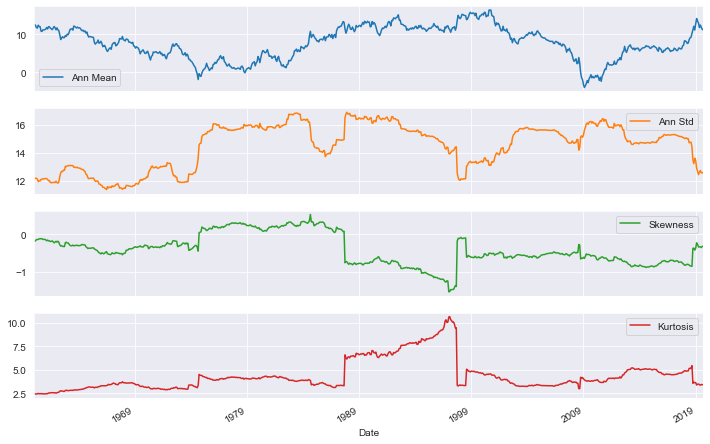

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rc("figure", figsize=(12,8))
ax = rolling.plot.line(subplots=True)